In [1]:
import os
import pandas as pd
import numpy as np
from pprint import pprint

In [2]:
df = pd.read_csv('../../data/raw/EV_sales.csv')

### EV Car Sales Between 2010 and 2024

#### About this file:
- region: Geographical area where the data was collected (e.g., Australia)
- category: Nature of the data (e.g., Historical, Projection)
- parameter: Type of metric (e.g., EV sales, EV stock share)
- mode: Mode of transport (e.g., Cars)
- powertrain: Type of EV: BEV (Battery Electric Vehicle), PHEV (Plug-in Hybrid - EV), EV
- year: Year of the data point (e.g., 2011, 2012)
- unit: Measurement unit (e.g., Vehicles, percent)
- value: Actual recorded value

#### Objective:

To know how are EVs evolving in three European markets (Spain, France and Germany) compared to the tendencies shown in the European Union. We want to know which are evolving faster, what are some strong and weak points, and to do some short term predictions for the year 2030 as per the objectives of the UN's 2030 Agenda.

In [3]:
df.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
1,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
2,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000


The first step, after getting a general idea of how the DF looks, is to drop the data that's not directly relevant or that doesn't provide any meaningful insight, and to leave only those that are worth studying deeper.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      3798 non-null   object 
 1   category    3798 non-null   object 
 2   parameter   3798 non-null   object 
 3   mode        3798 non-null   object 
 4   powertrain  3798 non-null   object 
 5   year        3798 non-null   int64  
 6   unit        3798 non-null   object 
 7   value       3798 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 237.5+ KB


In [5]:
columns = ['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit']

for column in columns:
    print(f"{column}'s unique values:\n{df[column].unique()}\n")

region's unique values:
['Australia' 'Austria' 'Belgium' 'Brazil' 'Bulgaria' 'Canada' 'Chile'
 'China' 'Colombia' 'Costa Rica' 'Croatia' 'Cyprus' 'Czech Republic'
 'Denmark' 'Estonia' 'EU27' 'Europe' 'Finland' 'France' 'Germany' 'Greece'
 'Hungary' 'Iceland' 'India' 'Ireland' 'Israel' 'Italy' 'Japan' 'Korea'
 'Latvia' 'Lithuania' 'Luxembourg' 'Mexico' 'Netherlands' 'New Zealand'
 'Norway' 'Poland' 'Portugal' 'Rest of the world' 'Romania' 'Seychelles'
 'Slovakia' 'Slovenia' 'South Africa' 'Spain' 'Sweden' 'Switzerland'
 'Turkiye' 'United Arab Emirates' 'United Kingdom' 'USA' 'World']

category's unique values:
['Historical']

parameter's unique values:
['EV sales' 'EV stock share' 'EV sales share' 'EV stock'
 'Electricity demand' 'Oil displacement Mbd'
 'Oil displacement, million lge']

mode's unique values:
['Cars']

powertrain's unique values:
['BEV' 'EV' 'PHEV' 'FCEV']

year's unique values:
[2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2010]

unit's unique values

Since both the "category" and the "mode" columns do not add any meaningful information to the database, it is safe to say we can drop them entirely from it, keeping in mind that all data is based on actual recorded measurements, and that all the vehicles present in the database are EV cars.

In [6]:
df = df.drop(columns=['category', 'mode'])

Additionally, since we are analysing only EV sales and their share in the market overall, it is safe to assume there is more information stored within the database than we need. Hence, it is necessary to clean up the data to keep only what is currently relevant for our study.

In [7]:
# Method A: By keeping only rows where the boolean returns "True"
units_to_remove = ['GWh', 'Milion barrels per day', 'Oil displacement, million lge']
df_units_cleaned = df[~df['unit'].isin(units_to_remove)]
# '~' negates the condition: it keeps only rows NOT containing unwanted units
df_units_cleaned['unit'].unique()

array(['Vehicles', 'percent'], dtype=object)

In [8]:
# Method B: By creating a copy only with the rows we want to keep
ev_parameters = ['EV sales', 'EV stock', 'EV sales share', 'EV stock share']
df_clean = df_units_cleaned[df_units_cleaned['parameter'].isin(ev_parameters)].copy()
df_clean['parameter'].unique()

array(['EV sales', 'EV stock share', 'EV sales share', 'EV stock'],
      dtype=object)

Note: Since both are directly correlated, by using only one of the previous steps, the database is already cleant. This is only for demonstration purposes.

In [9]:
df_clean[(df_clean['region']=='Australia') & (df_clean['year']==2012)]

,region,parameter,powertrain,year,unit,value
4,Australia,EV stock,BEV,2012,Vehicles,220.0000
5,Australia,EV stock,PHEV,2012,Vehicles,80.0000
6,Australia,EV sales,PHEV,2012,Vehicles,80.0000
7,Australia,EV sales share,EV,2012,percent,0.0300
8,Australia,EV stock share,EV,2012,percent,0.0024
9,Australia,EV sales,BEV,2012,Vehicles,170.0000


In the previous cell, we can observe that there are two different key units in this database to differenciate — Vehicle counts (physical stock and sales) and Percentages, over the total population of vehicles. The two units cannot be superposed, so it is necessary to separate them in two different sub-dataframes to separate cleanly the information in the following analysis.

In [10]:
df_vehicles = df[df['unit'] == 'Vehicles']
df_percent = df[df['unit'] == 'percent']

In [11]:
#df_percent.head(n=40)

Additionally, in df_vehicles, since all values must be integers (can't sell/stock half a car) the following helps making data clearer:

In [12]:
df_vehicles.loc[:, 'value'] = df_vehicles.loc[:, 'value'].astype(int)

Let's see what powertrain counts can be observed in the database for vehicles sold, so we can get an idea of what categories we can find:

In [13]:
df_vehicles['powertrain'].value_counts()

powertrain
BEV     1078
PHEV     922
FCEV     487
Name: count, dtype: int64

If we do the same with the newly created df_percent DF, we can observe that only one category 'EV' appears. That's something worth investigating, because the nature of the percentages shown is yet unknown and we should be able to see what is it saying. The following tests therefore try to observe the nature of said percentage.

Percentage change from 2021 to 2022:

In [14]:
# Checking annual variation in Australia in terms of percentage

years = [2021, 2022]
per_aus_22_23 = df_percent[(df_percent['region'] == 'Australia') & (df_percent['year'].isin(years)) & (df_percent['parameter'] == 'EV sales share')]

yearly_per_change = per_aus_22_23[['year','value']].reset_index(drop=True)
yearly_per_change.set_index('year')
yearly = yearly_per_change.set_index('year')

yearly['growth_pct'] = yearly['value'].pct_change() * 100
yearly



,value,growth_pct
year,,
2021,2.8,NaN
2022,5.1,82.142857


Percentage change from 2021 to 2022 (vehicles):

In [15]:
# Checking annual difference in Australia in terms of vehicles

years = [2021, 2022]
sales_aus_22_23 = df_vehicles[(df_vehicles['region'] == 'Australia') & (df_vehicles['year'].isin(years)) & (df_vehicles['parameter'] == 'EV sales')]

yearly_sales_change = sales_aus_22_23.groupby('year')['value'].sum().reset_index()
yearly_sales_change
yearly = yearly_sales_change.set_index('year')

yearly['growth_pct'] = yearly['value'].pct_change() * 100
yearly

,value,growth_pct
year,,
2021,20444.0,NaN
2022,38915.0,90.349247


While comparing year-over-year changes in EV sales, we observe that percentage-based indicators (EV sales share) do not align with growth measured in vehicle units. This is expected, as percentage metrics measure EV adoption relative to total vehicle sales (including ICE), whereas vehicle counts reflect absolute EV market expansion. Both perspectives are complementary and are therefore retained in the analysis, since we do not have, within the database, information about the total ICE sales in any country.

In [16]:
os.makedirs('../../data/processed/', exist_ok=True)
df_vehicles.to_csv('../../data/processed/EV_car_sales.csv', index=False)
df_percent.to_csv('../../data/processed/EV_per_sales.csv', index=False)

To end the exploratory analysis of the database, and its cleaning, we create two different csv's to be used to do a deep analysis of the current EV market in the selected countries, as seen in the following notebook.

### 1. EV Sales Analysis

In [17]:
import os
import pandas as pd
import numpy as np
from pprint import pprint
import sys
sys.path.append('../../scripts')
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df_vehicles = pd.read_csv('../../data/processed/EV_car_sales.csv')

We start by loading the new filtered csv's individually. Since this notebook will only work with the physical vehicle sales, we only load the previously created df_vehicles dataframe.

In [19]:
df_vehicles['parameter'].value_counts()

parameter
EV sales    1342
EV stock    1145
Name: count, dtype: int64

As we can observe, the database contains two distinct parameters for measuring electric vehicles: EV stock and EV sales. EV stock represents the total number of electric vehicles available in a country at a given time, while EV sales represent the number of vehicles actually sold during a specific period. Naturally, sales numbers should always be lower than stock, but analyzing the gap between them over recent years can offer valuable insights into the market’s growth dynamics and saturation levels.

The following distinction will be made, hence, to accomodate these two different data types.

In [20]:
df_vehicles_sales = df_vehicles[df_vehicles['parameter'] == 'EV sales']
df_vehicles_stock = df_vehicles[df_vehicles['parameter'] == 'EV stock']

### 1.1. EV Sales

First, lets analyse EV sales... how have they evolved in the world? In what categories are they classified? The analysis includes several overviews with insights regarding evolution through the years. All columns offer essential data regarding region and their own EV market evolution, as well as how each specific EV powertrain is doing in those regions...

But first of all, let's see the table we'll be working with to see if anything needs some work.

In [21]:
df_vehicles_sales

,region,parameter,powertrain,year,unit,value
0,Australia,EV sales,BEV,2011,Vehicles,49.0
4,Australia,EV sales,PHEV,2012,Vehicles,80.0
5,Australia,EV sales,BEV,2012,Vehicles,170.0
6,Australia,EV sales,BEV,2013,Vehicles,190.0
7,Australia,EV sales,PHEV,2013,Vehicles,100.0
...,...,...,...,...,...,...
2477,World,EV sales,FCEV,2022,Vehicles,15000.0
2479,World,EV sales,PHEV,2022,Vehicles,2900000.0
2482,World,EV sales,PHEV,2023,Vehicles,4300000.0
2484,World,EV sales,FCEV,2023,Vehicles,8900.0


In [22]:
columns = ['parameter', 'unit']

for column in columns:
    print(f"{column}'s unique values: \n{df_vehicles_sales[column].unique()}\n")

parameter's unique values: 
['EV sales']

unit's unique values: 
['Vehicles']



As expected, what were some essential columns previously, are now unnecessary as they do not provide any relevant information. These are known as "temporary indexing columns" and, in the four sub-databases we created, they will be deleted.

In [23]:
df_vehicles_sales = df_vehicles_sales.drop(['parameter','unit'], axis=1)

In [24]:
df_vehicles_sales

,region,powertrain,year,value
0,Australia,BEV,2011,49.0
4,Australia,PHEV,2012,80.0
5,Australia,BEV,2012,170.0
6,Australia,BEV,2013,190.0
7,Australia,PHEV,2013,100.0
...,...,...,...,...
2477,World,FCEV,2022,15000.0
2479,World,PHEV,2022,2900000.0
2482,World,PHEV,2023,4300000.0
2484,World,FCEV,2023,8900.0


In [25]:
df_vehicles_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1342 entries, 0 to 2486
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      1342 non-null   object 
 1   powertrain  1342 non-null   object 
 2   year        1342 non-null   int64  
 3   value       1342 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 52.4+ KB


So we are left with four columns, two of which are objects and help us categorise the data, one, year,  as integer values, and the last one, value, as the basis for the analysis with float values.

Knowing that, now lets include the python script to visualise data, using matplotlib and seaborn to graph them.

In [28]:
from ev_viz import year_plot

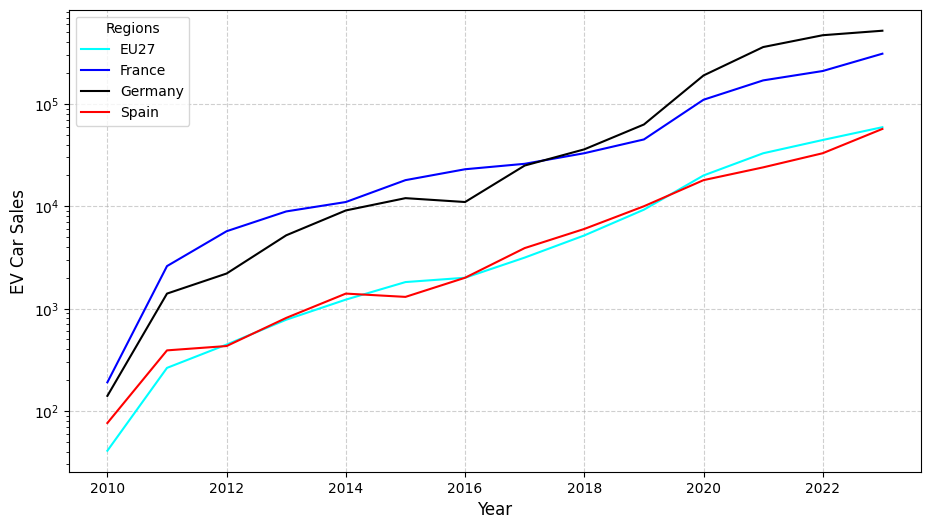

In [ ]:
# Using the previously defined function
year_plot(df_vehicles_sales, None, 'BEV', log=True)

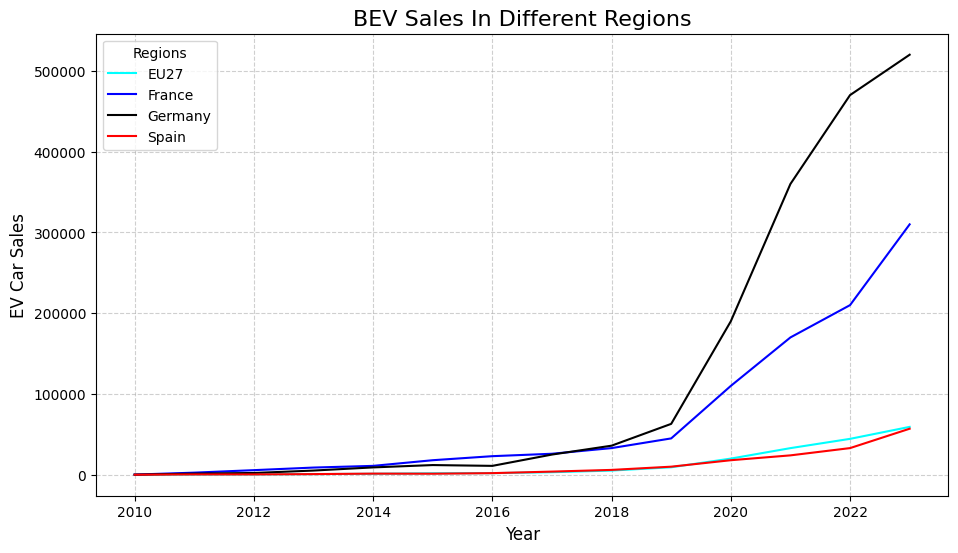

In [ ]:
countries = ['Spain', 'Germany', 'France', 'EU27']
bev_data = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'].isin(countries))]
# Adjusts the EU27 region to show the average between the 27 EU members
bev_data.loc[bev_data['region'] == 'EU27', 'value'] /= 27

fig, ax = plt.subplots(figsize=(11, 6))

palette = {
    'Spain': 'red',
    'Germany': 'black',
    'France': 'blue',
    'EU27': 'cyan'
}
sns.lineplot(data=bev_data, x='year', y='value', hue='region', palette=palette,linestyle='-')

ax.set_title('BEV Sales In Different Regions', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('EV Car Sales', fontsize=12)
ax.grid('True', linestyle='--', alpha=0.6)

plt.legend(title='Region/s')
plt.show()

We can already see an astonishing difference between the three countries by looking at the previous graph. Germany, being the biggest economy in the union, shows a way stronger trend towards electrification, pushed through and through by both government and car companies, with a breakthrough of 500k vehicles sold by the year 2023. However, a 

France, which lags a bit behind, also did an enormous progress with an even higher tendency, breaking the ceiling of 300k EVs sold by the year 2023 and with a way higher growth than Germany's, which we will explain before.

It is important to mention how, until the year 2018, sales in Spain and, in average, for the EU, were almost non-existant. Only a few thousand, with the exception of France and Germany in this case which hovered around the 40k sales. The increment afterwards however has been exponential, with the arrival of more mainstream EVs made in France and Germany, more affordable Tesla BEVs, and recent chinese BEVs penetrating these markets.

Tendencies, however, diverge. France and Germany show a clear gap, explained partially by the population difference between both countries, but also due to a stronger economy in Germany and more ability to purchase high end EVs where France lagged behind. However, last year showed how German sales stagnated a bit while French ones climbed at at a level never seen before, explained perhaps by more affordable EV cars produced in France, favoured by local consumers.

Spain, at the end, has seen a sharp rise last year, but is still under the EU average, with the possibility to break through at this rate if it is followed next year. However, despite being a very strong economy in the union, it is lagging severely behind and shows probably both reluctance by consumers, and a lack of government initiative to push for the transition.

In [ ]:
df_vehicles_sales['year']

0       2011
4       2012
5       2012
6       2013
7       2013
        ... 
2477    2022
2479    2022
2482    2023
2484    2023
2486    2023
Name: year, Length: 1342, dtype: int64

In [ ]:
fr_sales_2023 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'France') & (df_vehicles_sales['year'] == 2023), 'value'].sum()
fr_sales_2022 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'France') & (df_vehicles_sales['year'] == 2022), 'value'].sum()

ger_sales_2023 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'Germany') & (df_vehicles_sales['year'] == 2023), 'value'].sum()
ger_sales_2022 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'Germany') & (df_vehicles_sales['year'] == 2022), 'value'].sum()

spa_sales_2023 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'Spain') & (df_vehicles_sales['year'] == 2023), 'value'].sum()
spa_sales_2022 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'Spain') & (df_vehicles_sales['year'] == 2022), 'value'].sum()

eu27_sales_2023 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'EU27') & (df_vehicles_sales['year'] == 2023), 'value'].sum()
eu27_sales_2022 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'EU27') & (df_vehicles_sales['year'] == 2022), 'value'].sum()

fr_sales_growth = fr_sales_2023 / fr_sales_2022
ger_sales_growth = ger_sales_2023 / ger_sales_2022
spa_sales_growth = spa_sales_2023 / spa_sales_2022
eu27_sales_growth = eu27_sales_2023 / eu27_sales_2022
print(f"Last year's growth of EV sales was of {(fr_sales_growth-1)*100:.2f}% in France, {(ger_sales_growth-1)*100:.2f}% in Germany, {(spa_sales_growth-1)*100:.2f}% in Spain, while for the European Union it was of {(eu27_sales_growth-1)*100:.2f}%.")

Last year's growth of EV sales was of 47.62% in France, 10.64% in Germany, 72.73% in Spain, while for the European Union it was of 33.33%.


This bit of code is, arguably, excessively long, prone to bugs or errors, and very unreadable. In those cases, especially since the project relies on reusable, clean code that can be used later down the line, it is clear that is not the ideal way to read the evolution of data over the years. That's why down below I will use a modular function using python scripts.

Clean reusable code allows to obtain directly usable values that can be computed with a simple function call, and the function itself can be easily modified to adapt to other slightly different needs (as with EV percentages, which are not separated by powertrain types).

The function in particular used here is ```veh_evo```, and can be found within the following path: ```scripts/ev_utils.py```.

In [ ]:
# Reusable vehicle evolution function, from scripts:
import ev_utils
# Usage: per_evo(df_vehicles_sales, 'BEV', 'Germany', 2022, 2023, verbose=True)

The previous extensive function shows the practicity of Python functions to create reusable clean code that can be easily debugged. Using that, we can then proceed to print the outputs of the same things we calculated in the previous step to show how it works.

In [ ]:
countries = ['Germany', 'France', 'Spain', 'EU27']
powertrain = 'BEV'

for country in countries:
    veh_evo(df_vehicles_sales, powertrain, country, 2022, 2023, verbose=True)



For Germany region and BEV powertrain, the percentage change between 2022 and 2023 has been of 10.64%,
 with 470000 units in 2022, and 520000 units in 2023.
For France region and BEV powertrain, the percentage change between 2022 and 2023 has been of 47.62%,
 with 210000 units in 2022, and 310000 units in 2023.
For Spain region and BEV powertrain, the percentage change between 2022 and 2023 has been of 72.73%,
 with 33000 units in 2022, and 57000 units in 2023.
For EU27 region and BEV powertrain, the percentage change between 2022 and 2023 has been of 33.33%,
 with 1200000 units in 2022, and 1600000 units in 2023.


So we can see that in the last year of the scope (whole 2022 and whole 2023), the evolution between those three different European countries was radically different, and hint different tendencies, market expectations related to ecological motivation, economic power and industry expectations.

First, Germany, with a growth of only 10.64%, shows that the country did not rise at the pace expected and that sales on fully electric vehicles slowed down that could hint faster early market adaptation halting or government grants on EV vehicles being reduced/removed. It is important mentioning however that, even in that case, they account for almost 1/3rd of all BEV car sales in the European Union, showing they are still leading in the transition. In all cases, the growth was lower than as shown by the EU27, at over 3 times the growth pace.

France, on the other side, fared way better. Sales grew almost a 50%, showing increasing full EV adaptation probably caused by increased EV range, more affordable EV vehicles hitting the market and overall a better-than-average growth. They account for $\frac{310000}{1600000} \approx 19.4\%$ of all the BEV sales in 2023, closing the gap with Germany.

Finally, Spain, shows a much more reduced market for full electrics with only 57,000 units sold in 2023. However, there has been a growth of nearly 73% in sales, hinting  increasing demand pushed by lower costs, more accessibility to public charging and higher ranges. They do, however, still account for only $\frac{57000}{1600000} \approx 3.56\%$ of all EU sales despite being the second biggest car producer in the union.

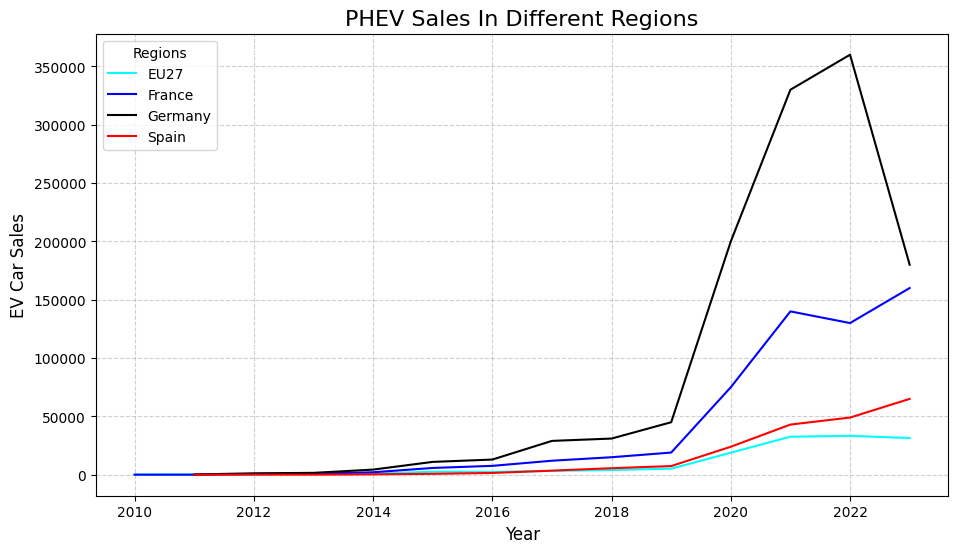

In [ ]:
countries = ['Spain', 'Germany', 'France', 'EU27']
bev_data = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'PHEV') & (df_vehicles_sales['region'].isin(countries))]
bev_data.loc[bev_data['region'] == 'EU27', 'value'] /= 27

fig, ax = plt.subplots(figsize=(11, 6))

palette = {
    'Spain': 'red',
    'Germany': 'black',
    'France': 'blue',
    'EU27': 'cyan'
}
sns.lineplot(data=bev_data, x='year', y='value', hue='region', palette=palette,linestyle='-')

ax.set_title('PHEV Sales In Different Regions', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('EV Car Sales', fontsize=12)
ax.grid('True', linestyle='--', alpha=0.6)

plt.legend(title='Regions')
plt.show()

In [ ]:
veh_evo(df_vehicles_sales, 'PHEV', 'Germany', 2022, 2023, verbose=True)
veh_evo(df_vehicles_sales, 'PHEV', 'France', 2022, 2023, verbose=True)
veh_evo(df_vehicles_sales, 'PHEV', 'Spain', 2022, 2023, verbose=True)
veh_evo(df_vehicles_sales, 'PHEV', 'EU27', 2022, 2023, verbose=True)

For Germany region and PHEV powertrain, the percentage change between 2022 and 2023 has been of -50.00%,
 with 360000 units in 2022, and 180000 units in 2023.
For France region and PHEV powertrain, the percentage change between 2022 and 2023 has been of 23.08%,
 with 130000 units in 2022, and 160000 units in 2023.
For Spain region and PHEV powertrain, the percentage change between 2022 and 2023 has been of 32.65%,
 with 49000 units in 2022, and 65000 units in 2023.
For EU27 region and PHEV powertrain, the percentage change between 2022 and 2023 has been of -5.56%,
 with 900000 units in 2022, and 850000 units in 2023.


np.float64(-5.555555555555558)

Even more strange is the evolution of plug-in electric vehicles, since somehow, those have gone down in a yoy scope, but for a clear reason.

Spain and France both leaded with a significant growth of their share, with a 23% and nearly a 33% respectively. This growth is important to ensure, among other things, that the plans proposed by the UN's 2030 Agenda can be fulfilled, and to reach lower emissions within cities. 

However, one that does strike quite a lot is Germany's sales, since they effectively plummeted, dropping a 50% just this year. While predictions can be made, a quick search shows that government subsides ended that very same year, and therefore the cost of purchase of plug-in electric vehicles skyrocketed. Other countries seem to have kept their fleet renewal subsidies up, showing that the tendency with stable prices is of a market transition towards more ecological vehicles.

The EU27's average however hasn't really been massively affected by this drop, and as shown by the graph, neither by the previous spike during 2021 and 2022 by Germany's market. This unusual behaviour can be affected by many countries such as Italy, Poland, Ireland or Norway, but that being out of scope, the only thing we can safely assume is that the tendency overall is positive as long as stable conditions are kept in place.

### 1.2. EV Stock


In [ ]:
years_early = [2010, 2011, 2012]
years_late = [2021, 2022, 2023]
df_vehicles_stock[(df_vehicles_stock['region'] == 'World') & (df_vehicles_stock['year'].isin(years_early))]

,region,parameter,powertrain,year,unit,value
2404,World,EV stock,BEV,2010,Vehicles,20000.0
2406,World,EV stock,FCEV,2010,Vehicles,45.0
2408,World,EV stock,PHEV,2010,Vehicles,400.0
2409,World,EV stock,PHEV,2011,Vehicles,9500.0
2411,World,EV stock,FCEV,2011,Vehicles,83.0
2413,World,EV stock,BEV,2011,Vehicles,58000.0
2416,World,EV stock,BEV,2012,Vehicles,120000.0
2418,World,EV stock,FCEV,2012,Vehicles,110.0
2420,World,EV stock,PHEV,2012,Vehicles,70000.0


In [ ]:
years_early = [2010, 2011, 2012]
years_late = [2021, 2022, 2023]
df_vehicles_stock[(df_vehicles_stock['region'] == 'World') & (df_vehicles_stock['year'].isin(years_early))]

,region,parameter,powertrain,year,unit,value
2404,World,EV stock,BEV,2010,Vehicles,20000.0
2406,World,EV stock,FCEV,2010,Vehicles,45.0
2408,World,EV stock,PHEV,2010,Vehicles,400.0
2409,World,EV stock,PHEV,2011,Vehicles,9500.0
2411,World,EV stock,FCEV,2011,Vehicles,83.0
2413,World,EV stock,BEV,2011,Vehicles,58000.0
2416,World,EV stock,BEV,2012,Vehicles,120000.0
2418,World,EV stock,FCEV,2012,Vehicles,110.0
2420,World,EV stock,PHEV,2012,Vehicles,70000.0


We can already observe very different values between both metrics. The massive difference is beyond the one I first expected, but the explanation is structural - stock corresponds to the vehicles on the road, not just to the vehicles sold. That's the reason that if we compare the early years (such as, when PHEV vehicles started to be introduced for the first time) we can observe that the difference is nowhere near as big as in the later years of the data, concluding that the stock is cumulative. This could help to obtain information, even if its out of scope, about reliability, costs and road-worthiness if more data was available.

What is interesting, however, is the share of on-going vehicles on the roads for the countries of our study, how common they are, and what this can say about their presence in the road and how impactful this is in our daily life—even more when comparing the percentage of EV stock in our roads compared to ICE cars later on.

In [ ]:
years_early = [2010, 2011, 2012]
irrelevant_powertrain = ['FCEV']
df_vehicles_stock[(df_vehicles_stock['region'] == 'Germany') & (df_vehicles_stock['year'].isin(years_early)) & (~df_vehicles_stock['powertrain'].isin(irrelevant_powertrain))]

,region,parameter,powertrain,year,unit,value
912,Germany,EV stock,BEV,2010,Vehicles,250.0
917,Germany,EV stock,BEV,2011,Vehicles,1600.0
920,Germany,EV stock,PHEV,2011,Vehicles,240.0
921,Germany,EV stock,PHEV,2012,Vehicles,1400.0
924,Germany,EV stock,BEV,2012,Vehicles,3900.0


In [ ]:
powertrains = ['BEV', 'PHEV']

for powertrain in powertrains:
    veh_evo(df_vehicles_stock, powertrain, 'Germany', 2022, 2023, verbose=True)

For Germany region and BEV powertrain, the percentage change between 2022 and 2023 has been of 50.00%,
 with 1000000 units in 2022, and 1500000 units in 2023.
For Germany region and PHEV powertrain, the percentage change between 2022 and 2023 has been of 16.28%,
 with 860000 units in 2022, and 1000000 units in 2023.


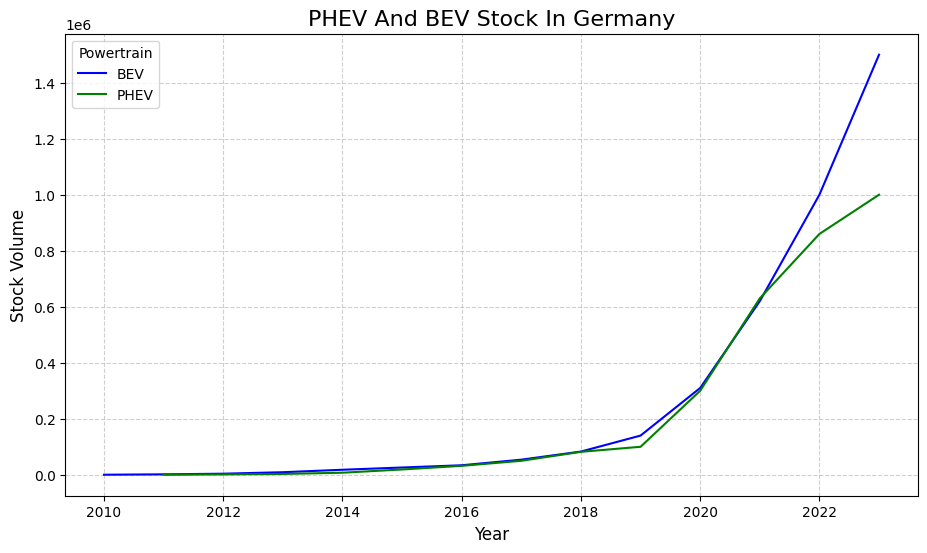

In [ ]:
countries = ['Germany']
powertrain = ['BEV', 'PHEV']
bev_data = df_vehicles_stock.loc[(df_vehicles_stock['powertrain'].isin(powertrain)) & (df_vehicles_stock['region'].isin(countries))]

fig, ax = plt.subplots(figsize=(11, 6))

palette = {
    'PHEV': 'green',
    'BEV': 'blue'
}

sns.lineplot(data=bev_data, x='year', y='value', hue='powertrain', palette=palette,linestyle='-')

ax.set_title('PHEV And BEV Stock In Germany', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Stock Volume', fontsize=12)
ax.grid('True', linestyle='--', alpha=0.6)

plt.legend(title='Powertrain')
plt.show()

There is an instant, important insight we can observe here over what we saw with car sales of PHEV and BEV vehicles in Germany: The road stock did not increase anywhere near the rate of BEV vehicles, despite both having similar beginnings (PHEV vehicles actually not appearing until 2011, one year after fully electric vehicles, and at a slower rate). This suggests a reduced demand for PHEVs in that year, likely influenced by policy changes in Germany, since in the EU27 there was a road stock increase of 34.62% (as shown in the next cell). However, good news is that registered BEV cars on the road are emission-free at the tailpipe, so even if we compare tendencies, we can safely say that, at this rate, zero emission vehicles are overtaking plug-in hybrids in the German market.

In [ ]:
countries = ['Germany', 'Spain', 'EU27']
powertrain = 'BEV'

for country in countries:
    veh_evo(df_vehicles_stock, powertrain, country, 2022, 2023, verbose=True)


For Germany region and BEV powertrain, the percentage change between 2022 and 2023 has been of 50.00%,
 with 1000000 units in 2022, and 1500000 units in 2023.
For Spain region and BEV powertrain, the percentage change between 2022 and 2023 has been of 66.67%,
 with 96000 units in 2022, and 160000 units in 2023.
For EU27 region and BEV powertrain, the percentage change between 2022 and 2023 has been of 53.33%,
 with 3000000 units in 2022, and 4600000 units in 2023.


In [ ]:
powertrain = ['PHEV']
df_vehicles_stock[(df_vehicles_stock['region'] == 'Spain') & (df_vehicles_stock['powertrain'].isin(powertrain))]

,region,parameter,powertrain,year,unit,value
2002,Spain,EV stock,PHEV,2011,Vehicles,8.0
2003,Spain,EV stock,PHEV,2012,Vehicles,120.0
2010,Spain,EV stock,PHEV,2013,Vehicles,190.0
2011,Spain,EV stock,PHEV,2014,Vehicles,520.0
2018,Spain,EV stock,PHEV,2015,Vehicles,1300.0
2019,Spain,EV stock,PHEV,2016,Vehicles,2800.0
2026,Spain,EV stock,PHEV,2017,Vehicles,6300.0
2027,Spain,EV stock,PHEV,2018,Vehicles,12000.0
2038,Spain,EV stock,PHEV,2019,Vehicles,19000.0
2039,Spain,EV stock,PHEV,2020,Vehicles,43000.0


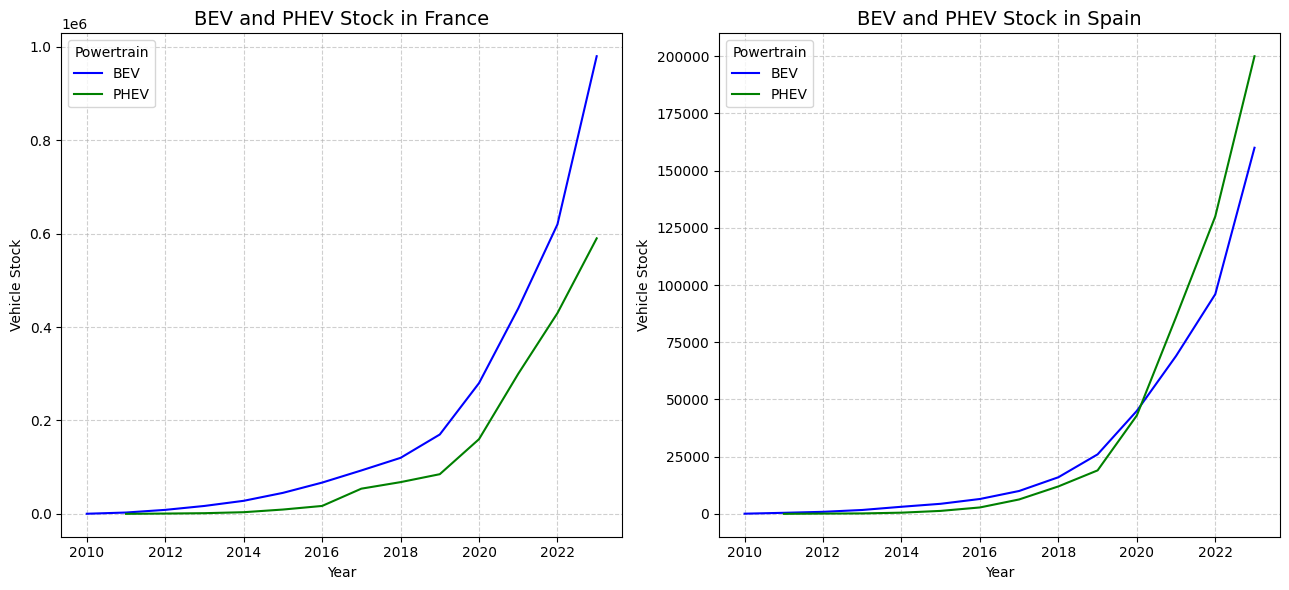

In [ ]:
countries = ['France', 'Spain']
powertrain = ['BEV', 'PHEV']
bev_data = df_vehicles_stock.loc[(df_vehicles_stock['powertrain'].isin(powertrain)) & (df_vehicles_stock['region'].isin(countries))]

fig, ax = plt.subplots(1, 2, figsize=(13, 6))

palette = {
    'PHEV': 'green',
    'BEV': 'blue'
}

for ax, country in zip(ax, countries):
    
    data = df_vehicles_stock.loc[(df_vehicles_stock['region'] == country) & (df_vehicles_stock['powertrain'].isin(powertrain))]

    sns.lineplot(data=data, x='year', y='value', hue='powertrain', palette=palette, ax=ax)

    ax.set_title(f'BEV and PHEV Stock in {country}', fontsize=14)
    ax.set_xlabel('Year')
    ax.set_ylabel('Vehicle Stock')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title='Powertrain')

plt.tight_layout()
plt.show()

In [ ]:
years = [2023]
powertrain = ['PHEV', 'BEV']
df_vehicles_stock[(df_vehicles_stock['region'] == 'Spain') & (df_vehicles_stock['powertrain'].isin(powertrain)) & (df_vehicles_stock['year'].isin(years))]

,region,parameter,powertrain,year,unit,value
2059,Spain,EV stock,BEV,2023,Vehicles,160000.0
2062,Spain,EV stock,PHEV,2023,Vehicles,200000.0


Now, if we instead compare Germany with our other two study countries, Spain and France, we can observe how huge the drop is in registrations and the reach of the slowdown.

In France, the registrations reached an all-high of 590k units registered on the roads, compared to the 430k the year before. This is equal to a $\frac{160000}{430000} \approx 37.2\%$ of increase in just one year, a massive growth year-on-year. Spain has had an ever more substantial 53.85% of growth in 2023 over the past year, far below France at 200k units, but showing also a clear upwards trend that has strong chances to make, in a few years notice, traditional hybrid and ICE vehicles less prominent in the roads (as will be shown in future predictive models).

Relevant to the analysis is the evolution observed in both BEV and PHEV sales in both France and Spain. In the former, by the year 2023, BEVs represent a near 40% higher volume of road stock than PHEVs, and while the gap has gotten bigger last year, PHEVs simply took longer to appear in the french market and the gap is structural and probably more related to their late adoption than a fundamental priorisation of fully electric vehicles.

On the other side, the Spanish market, dominated by cheaper car and foreign vehicles, shows a different tendency. PHEVs started slower, like in France, but BEVs never took off in the same manner as in the other european countries, in fact being surpased in 2020 by a substantial margin. By 2023, the gap stays at a +20% that of fully electric vehicles, probably due to infrastructure, cost and overall a historic preference for the Spanish market towards traditional ICE vehicles.

An important mention is also the gap between France and Germany, and Spain, the former having both 1 million BEVs and 1.4 million BEVs on their roads, respectively, over the later, at just 160k BEVs. A mix of older car fleet and reluctance to adapt to alternative fuels (charging stations, prices...) could explain it, but the most relevant insight is that it shows great disparity even amongst the main economies in the European Union.

In [ ]:
powertrain = ['PHEV', 'BEV']
df_vehicles_stock[(df_vehicles_stock['region'] == 'EU27') & (df_vehicles_stock['powertrain'].isin(powertrain))]

,region,parameter,powertrain,year,unit,value
611,EU27,EV stock,BEV,2010,Vehicles,4900.0
615,EU27,EV stock,PHEV,2010,Vehicles,40.0
616,EU27,EV stock,PHEV,2011,Vehicles,430.0
620,EU27,EV stock,BEV,2011,Vehicles,12000.0
623,EU27,EV stock,BEV,2012,Vehicles,23000.0
627,EU27,EV stock,PHEV,2012,Vehicles,7900.0
628,EU27,EV stock,PHEV,2013,Vehicles,33000.0
632,EU27,EV stock,BEV,2013,Vehicles,44000.0
635,EU27,EV stock,BEV,2014,Vehicles,75000.0
639,EU27,EV stock,PHEV,2014,Vehicles,57000.0


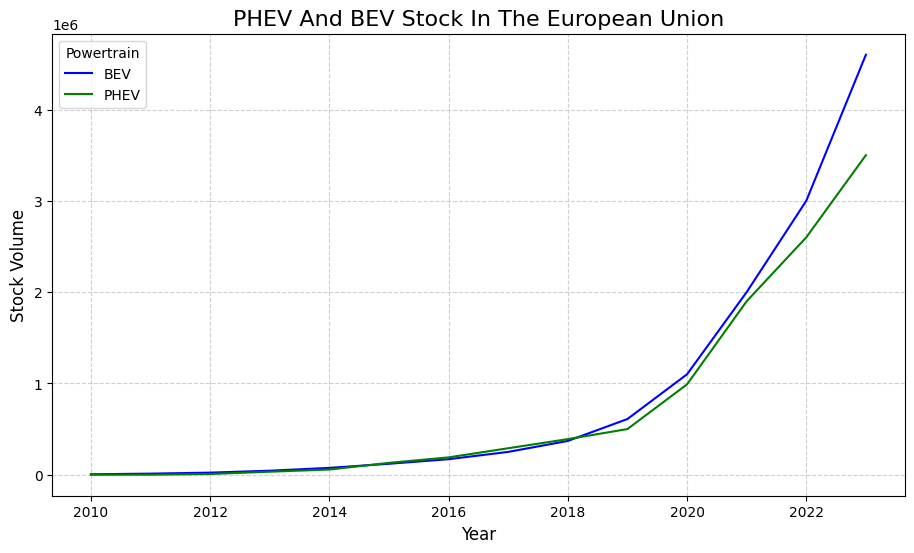

In [ ]:
countries = ['EU27']

powertrain = ['BEV', 'PHEV']
bev_data = df_vehicles_stock.loc[(df_vehicles_stock['powertrain'].isin(powertrain)) & (df_vehicles_stock['region'].isin(countries))]

fig, ax = plt.subplots(figsize=(11, 6))

palette = {
    'PHEV': 'green',
    'BEV': 'blue'
}

sns.lineplot(data=bev_data, x='year', y='value', hue='powertrain', palette=palette,linestyle='-')

ax.set_title('PHEV And BEV Stock In The European Union', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Stock Volume', fontsize=12)
ax.grid('True', linestyle='--', alpha=0.6)

plt.legend(title='Powertrain')
plt.show()

A final relevant insight to the study is the fact PHEV vehicles have actually grown at a slower rate than zero emission BEV vehicles all over the EU27, which in terms of alternate fuel engines, is very good news towards achieving carbon-neutral transportation and zero emission car sales by 2035. We can even observe how road stock is recently higher for BEV vehicles in the entire union, making zero emission vehicles the main alternative fuel choice for road users. Not only that, but despite an initial higher success of PHEV vehicles, by 2018 fully electric vehicles surpassed them, and we can observe than the gap got increasingly bigger year after year. And despite most of this volume being attributed to Germany, France and overall west-north Europe, its a change in the good direction that seems to just grow exponentially.

### 2. EV Percentage Analysis

In [ ]:
import os
import pandas as pd
import numpy as np
from pprint import pprint
import sys
sys.path.append('../scripts')
import matplotlib.pyplot as plt
import seaborn as sns

The previous analysis already gives us a brief review on the evolution of car sales and stock, in volume, per countries, focusing on Germany, France and Spain. However, there is still a key piece of information: Data relative to total vehicle sales, and stock, in each market.

As we could verify at the beginning of the data cleaning, the data found when we filter by percentage units correspond to share compared to two metrics:

- Percentage of Sales: The share of new vehicle sales in a given year accounted for by each vehicle type.
- Percentage of Stock: The share of vehicles of that type within the total registered fleet (cars still in circulation).

This is confirmed by the much higher sales share of those type of vehicles in recent years, and the much slower rising stock of those very same vehicles, since the total vehicle stock is relative to the vehicle registration lifespan.

In [ ]:
df_percent = pd.read_csv('../../data/processed/EV_per_sales.csv')

In [ ]:
df_percent_sales = df_percent[df_percent['parameter'] == 'EV sales share']
df_percent_stock = df_percent[df_percent['parameter'] == 'EV stock share']

In [ ]:
df_percent_stock[df_percent_stock['region'] == 'Germany']

,region,parameter,powertrain,year,unit,value
374,Germany,EV stock share,EV,2010,percent,0.00058
377,Germany,EV stock share,EV,2011,percent,0.00440
378,Germany,EV stock share,EV,2012,percent,0.01200
381,Germany,EV stock share,EV,2013,percent,0.02800
382,Germany,EV stock share,EV,2014,percent,0.05600
385,Germany,EV stock share,EV,2015,percent,0.09700
386,Germany,EV stock share,EV,2016,percent,0.14000
389,Germany,EV stock share,EV,2017,percent,0.22000
390,Germany,EV stock share,EV,2018,percent,0.35000
393,Germany,EV stock share,EV,2019,percent,0.50000


In the previous dataframe we can already see how the percentage, on what we can safely predict is EV sales (that is, alternative combustion vehicles) relates to the sales of vehicles, and the big variation between years shows it must be over the total volume of sold cars per year. Therefore, for this particular case in the German market, the values show that despite a growing tendency until 2022, something perhaps related to cost or regulation happened the next year that reduced their share over the total. In this particular case its important to see that despite the overall number of EV cars being sold did increase in this period in a 10% for Germany, their share got reduced, despite the hint at a hidden market growth of total vehicles sold. We can therefore make a calculation in the following cell that shows it better:

In [ ]:
# Reusable percentage evolution function, from scripts:
from ev_utils import per_evo
# Usage: per_evo(df_percentage_sales, 'BEV', 'Germany', 2022, 2023, verbose=True)

In [ ]:
per_evo(df_percent_sales, 'Germany', 2022, 2023, verbose=True)
per_evo(df_percent_stock, 'Germany', 2022, 2023, verbose=False)

For Germany, the percentage change for EV sales share between 2022 and 2023 has been of -22.58%,
with 31.00% in 2022, and 24.00% in 2023.
Also, the percentage change for EV stock share between 2022 and 2023 has been of 38.46%,
with 3.90% in 2022, and 5.40% in 2023.


As we already clarified, the percentage evolution is not really an interesting measure as such by itself, since they are a measure that's especially relevant towards getting the market's big picture: How big is the market for alternative fuel cars over the total (mainly, petrol and diesel)? That information is something we can observe more easily through the data itself rather than this evolution function, though it does help seeing patterns.

For instance, Germany's harmed EV market did not translate to a reduced stock in the market, but a slowdown in adoption. This is a negative outcome towards policy making and market adoption, but it does not mean reduced interest or changing dynamics, but rather, a temporary shock that delayed their emergence, as despite the considerably reduced volume of sale share against ICE cars in 2023 (a 23% less than in 2022), the road stock has grown a nearly 40% in the same period, which is a very positive value given the context.

In [ ]:
per_evo(df_percent_sales, 'France', 2022, 2023, verbose=True)
per_evo(df_percent_stock, 'France', 2022, 2023)
print("\n")
per_evo(df_percent_sales, 'Spain', 2022, 2023, verbose=True)
per_evo(df_percent_stock, 'Spain', 2022, 2023)
print("\n")
per_evo(df_percent_sales, 'EU27', 2022, 2023, verbose=True)
per_evo(df_percent_stock, 'EU27', 2022, 2023)

For France, the percentage change for EV sales share between 2022 and 2023 has been of 25.00%,
with 20.00% in 2022, and 25.00% in 2023.
Also, the percentage change for EV stock share between 2022 and 2023 has been of 46.43%,
with 2.80% in 2022, and 4.10% in 2023.


For Spain, the percentage change for EV sales share between 2022 and 2023 has been of 34.83%,
with 8.90% in 2022, and 12.00% in 2023.
Also, the percentage change for EV stock share between 2022 and 2023 has been of 59.57%,
with 0.94% in 2022, and 1.50% in 2023.


For EU27, the percentage change for EV sales share between 2022 and 2023 has been of 4.76%,
with 21.00% in 2022, and 22.00% in 2023.
Also, the percentage change for EV stock share between 2022 and 2023 has been of 44.00%,
with 2.50% in 2022, and 3.60% in 2023.


The picture is similar is better for the French market — the increase of sales share for EVs went up to 25% of the total, and the road stock for them increased substantially, by a 46.43%. Therefore, we can conclude that the 
french market has a healthy incline, shows no signs of slowing down, and closed the gap slightly with Germany's market despite still being slower into the transition. The increase of French-made low-cost EVs should positively further influence their adoption in the following years.

The Spanish market, however, is still lagging in absolute terms, yet it shows the largest year-on-year increase among major European markets. The road stock grew from 0.94% to 1.50% of total vehicles, demonstrating strong 
relative growth despite remaining small in total numbers, and a lower stock increase compared to the average in the union, but with a substantially better sales share evolution (sales in the union stagnated that year). 

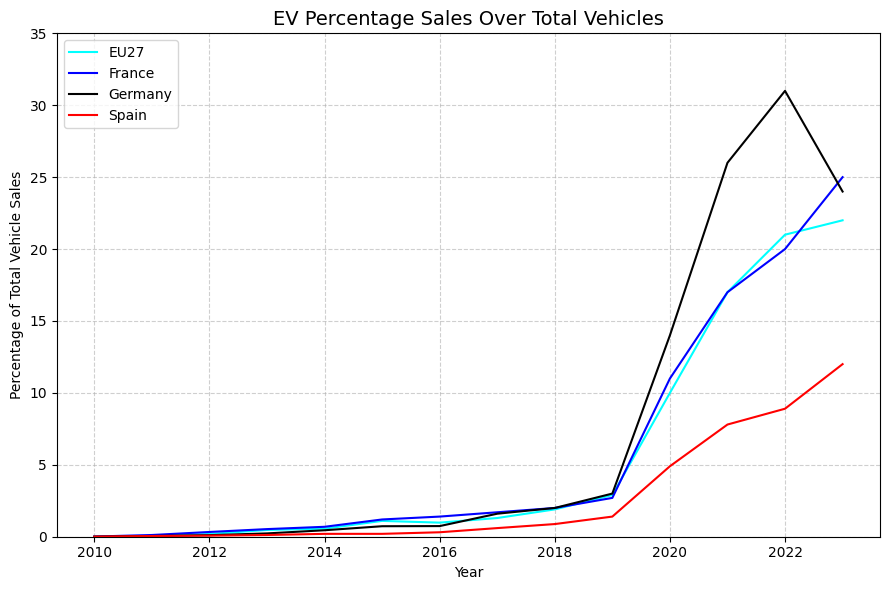

In [ ]:
countries = ['France', 'Spain', 'Germany', 'EU27']
bev_data = df_percent_sales.loc[df_percent_sales['region'].isin(countries)]

fig, ax = plt.subplots(figsize=(9, 6))

palette = {
    "France": 'blue',
    "Spain": 'Red',
    "Germany": 'Black',
    'EU27': "Cyan"
}

sns.lineplot(data=bev_data, x='year', y='value', hue='region', palette=palette, ax=ax)

ax.set_title(f'EV Percentage Sales Over Total Vehicles', fontsize=14)
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Total Vehicle Sales')
ax.set_ylim(0, 35)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

Tendencies are surprisingly similar between France and Spain, only variating in terms of volume. The same could be said by Germany after 2019, was it not by the sudden shock after the PHEV aid removal that took place at the beginning of 2023. It is quite hard to gauge exactly what effect would this shock have had, had it taken place in France or Spain. In the not-so-distant future, this could be a reality, and it could more clearly display tendencies towards electrification of car fleets.

Unsurprisingly, Germany's huge volume reduction that year dragged down the growth seen all over the union, yet on average, the proportion of EV sales has only been growing since 2016.

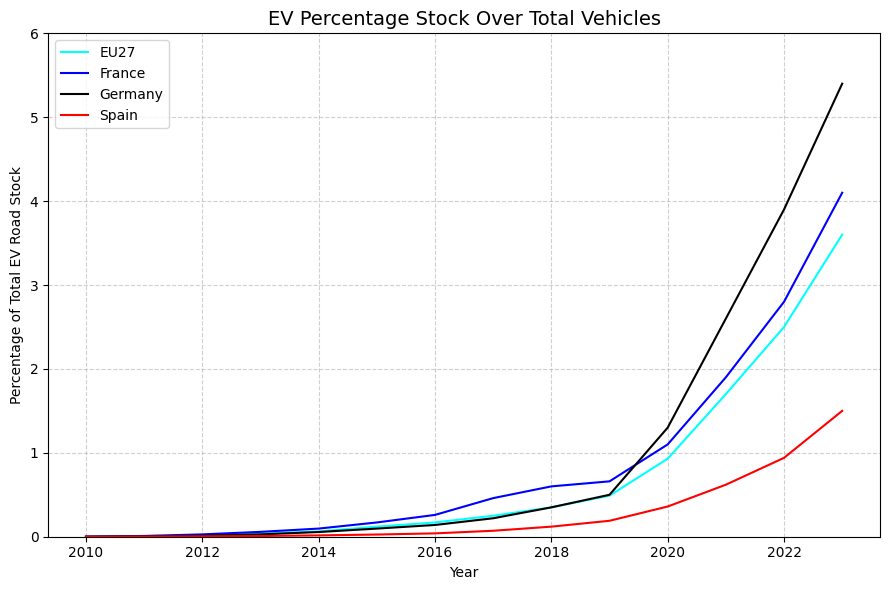

In [ ]:
countries = ['France', 'Spain', 'Germany', 'EU27']
bev_data = df_percent_stock.loc[df_percent_stock['region'].isin(countries)]

fig, ax = plt.subplots(figsize=(9, 6))

palette = {
    "France": 'blue',
    "Spain": 'Red',
    "Germany": 'Black',
    'EU27': "Cyan"
}

sns.lineplot(data=bev_data, x='year', y='value', hue='region', palette=palette, ax=ax)

ax.set_title(f'EV Percentage Stock Over Total Vehicles', fontsize=14)
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Total EV Road Stock')
ax.set_ylim(0, 6)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

In this final graph analysis, we can observe how the real road stock between countries has done nothing but grow (due to a very high volume of sales over the total), and more clearly shows the most important picture in the whole database: How much of the total vehicle market uses alternative, more ecological propulsion systems, and how are faring the countries of our study thus far.

And when doing that, we can observe that Germany is growing at a healthy rate, and by 2023 its market has 50% more EVs than the average of the European Union, and France is performing also above the average by a slight margin. Spain, on the contrary, underperforms both in tendency and stock for 2023, since it had a delayed market transformation that could take two or three more years to equal the european average.

### 3. Prediction Models (WIP)

In the following section, we seek to expand on the idea we proposed before — where will we be, using current growth trends, by 2030? This is no easy task and could be developed with extensive depth, but the objective here is to showcase the different tools that the scikit-learn library gives us to predict if the goals set by different organisations over the European Union

In [ ]:
from sklearn import linear_model

### 4. Key Factors To Consider